# Mouse duodenum 

paper: https://www.biorxiv.org/content/10.1101/2023.06.07.544052v1 

## All cells

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Get the original magma colormap
magma = plt.cm.get_cmap('magma', 256)

# Convert to array and prepend grey
magma_colors = magma(np.linspace(0, 1, 256))
grey = np.array([[0.8, 0.8, 0.8, 1.0]])  # RGBA for light grey

# Combine: grey for near-zero, then rest of magma
new_colors = np.vstack((grey, magma_colors[20:]))  # skip darkest part of magma
custom_cmap1 = ListedColormap(new_colors)

In [3]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt" 
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)

In [81]:
adata_f1 = sc.read_mtx('GSM7372101_F1_matrix.mtx.gz').T
genes_f1 = pd.read_csv('GSM7372101_F1_features.tsv.gz', header=None, sep="\t")
adata_f1.var.index = genes_f1[1].values
barcodes_f1 = pd.read_csv('GSM7372101_F1_barcodes.tsv.gz', header=None, sep='\t')
adata_f1.obs.index = barcodes_f1[0].values

In [82]:
adata_f2 = sc.read_mtx('GSM7372102_F2_matrix.mtx.gz').T
genes_f2 = pd.read_csv('GSM7372102_F2_features.tsv.gz', header=None, sep="\t")
adata_f2.var.index = genes_f2[1].values
barcodes_f2 = pd.read_csv('GSM7372102_F2_barcodes.tsv.gz', header=None, sep='\t')
adata_f2.obs.index = barcodes_f2[0].values

In [83]:
adata_m1 = sc.read_mtx('GSM7372103_M1_matrix.mtx.gz').T
genes_m1 = pd.read_csv('GSM7372103_M1_features.tsv.gz', header=None, sep="\t")
adata_m1.var.index = genes_m1[1].values
barcodes_m1 = pd.read_csv('GSM7372103_M1_barcodes.tsv.gz', header=None, sep='\t')
adata_m1.obs.index = barcodes_m1[0].values

In [84]:
adata_m2 = sc.read_mtx('GSM7372104_M2_matrix.mtx.gz').T
genes_m2 = pd.read_csv('GSM7372104_M2_features.tsv.gz', header=None, sep="\t")
adata_m2.var.index = genes_m2[1].values
barcodes_m2 = pd.read_csv('GSM7372104_M2_barcodes.tsv.gz', header=None, sep='\t')
adata_m2.obs.index = barcodes_m2[0].values

In [85]:
adata_f1_raw = adata_f1.copy()
adata_f2_raw = adata_f2.copy()
adata_m1_raw = adata_m1.copy()
adata_m2_raw = adata_m2.copy()

In [86]:
def preprocess_adata(adata):

    # Ensure unique gene names to prevent reindexing errors
    adata.var_names_make_unique()
    
    # Mark mitochondrial and ribosomal genes
    adata.var['mt'] = adata.var_names.str.startswith("mt-")
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=['mt', 'ribo'],
        percent_top=None,
        log1p=False,
        inplace=True
    )

    # Filter cells and genes
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=5)

    # Mitochondrial filtering
    adata = adata[adata.obs['pct_counts_mt']<5]

    # Filtering cells by Kcnq1ot1 % contribution
    X = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X
    kcnq1ot1_idx = np.where(adata.var_names == "Kcnq1ot1")[0][0]
    kcnq1ot1_expr = X[:, kcnq1ot1_idx]
    total_kcnq1ot1 = kcnq1ot1_expr.sum()
    contrib_fraction = kcnq1ot1_expr / total_kcnq1ot1
    keep_cells = contrib_fraction <= 0.02
    adata = adata[keep_cells].copy()

    # Normalize and log-transform
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    return adata

In [87]:
adata_combined = sc.concat((preprocess_adata(adata) for adata in [adata_f1, adata_f2, adata_m1, adata_m2]), 
                           label='batch', 
                           keys=['F1', 'F2', 'M1', 'M2'])

In [88]:
adata_combined.obs_names_make_unique()

In [89]:
gadata = adata_combined.copy()

In [90]:
sc.pp.highly_variable_genes(adata_combined, flavor='seurat', batch_key='batch', n_top_genes=2000)
adata_combined.raw = adata_combined.copy()
adata_combined = adata_combined[:, adata_combined.var.highly_variable].copy()

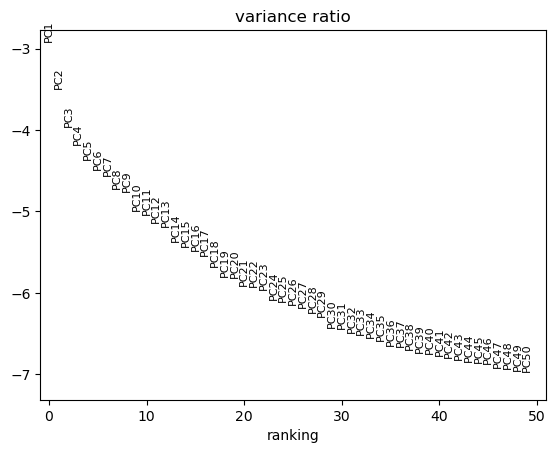

In [91]:
sc.pp.scale(adata_combined, max_value=10)
sc.tl.pca(adata_combined, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_combined, log=True, n_pcs = 50)

In [92]:
sc.external.pp.harmony_integrate(adata_combined, key='batch')
sc.pp.neighbors(adata_combined, n_neighbors = 30, n_pcs = 50, use_rep='X_pca_harmony')
sc.tl.umap(adata_combined)

2025-06-27 12:51:51,990 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-27 12:51:55,228 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-27 12:51:55,442 - harmonypy - INFO - Iteration 1 of 10
2025-06-27 12:52:03,735 - harmonypy - INFO - Iteration 2 of 10
2025-06-27 12:52:12,196 - harmonypy - INFO - Iteration 3 of 10
2025-06-27 12:52:20,625 - harmonypy - INFO - Iteration 4 of 10
2025-06-27 12:52:29,015 - harmonypy - INFO - Iteration 5 of 10
2025-06-27 12:52:33,154 - harmonypy - INFO - Iteration 6 of 10
2025-06-27 12:52:36,561 - harmonypy - INFO - Iteration 7 of 10
2025-06-27 12:52:39,977 - harmonypy - INFO - Iteration 8 of 10
2025-06-27 12:52:42,982 - harmonypy - INFO - Iteration 9 of 10
2025-06-27 12:52:46,114 - harmonypy - INFO - Converged after 9 iterations


In [93]:
sc.tl.leiden(adata_combined, resolution = 1)

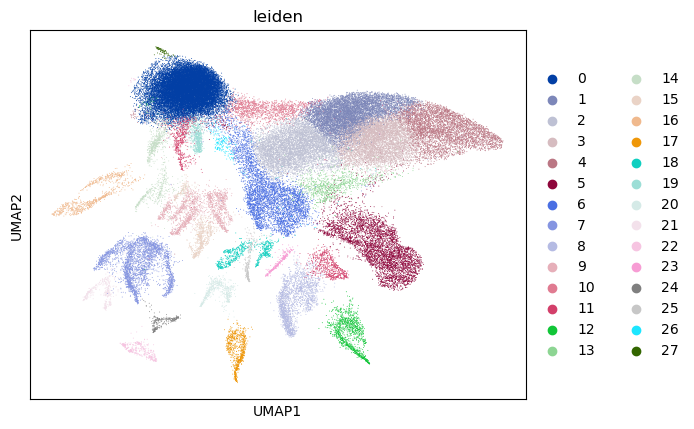

In [94]:
sc.pl.umap(adata_combined, color=['leiden'], use_raw=True)

In [58]:
adata_combined.obs['is cluster 22'] = adata_combined.obs['leiden'].map({'22': True})

In [59]:
adata_combined.obs['is cluster 24'] = adata_combined.obs['leiden'].map({'24': True})

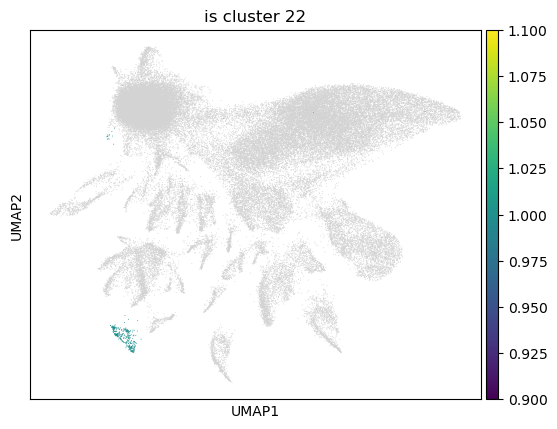

In [60]:
sc.pl.umap(adata_combined, color=['is cluster 22'], use_raw=True)

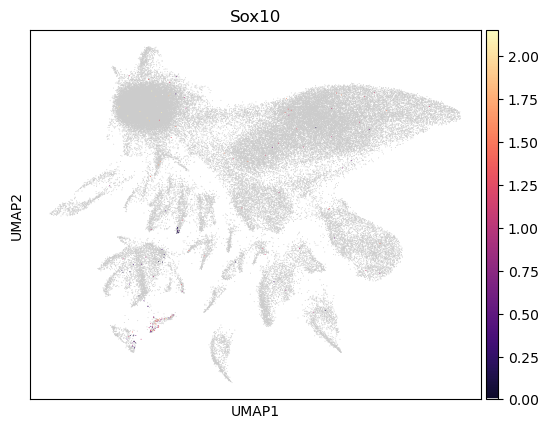

In [61]:
sc.pl.umap(adata_combined, color=['Sox10'], use_raw=True, cmap=custom_cmap1)

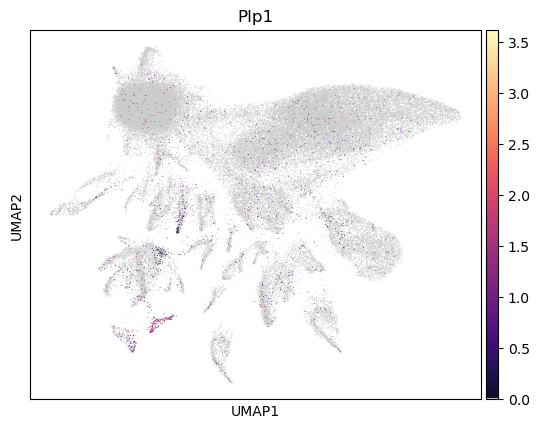

In [62]:
sc.pl.umap(adata_combined, color=['Plp1'], use_raw=True, cmap=custom_cmap1)

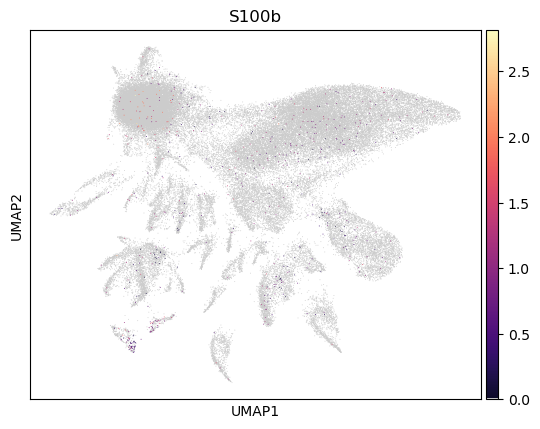

In [63]:
sc.pl.umap(adata_combined, color=['S100b'], use_raw=True, cmap=custom_cmap1)

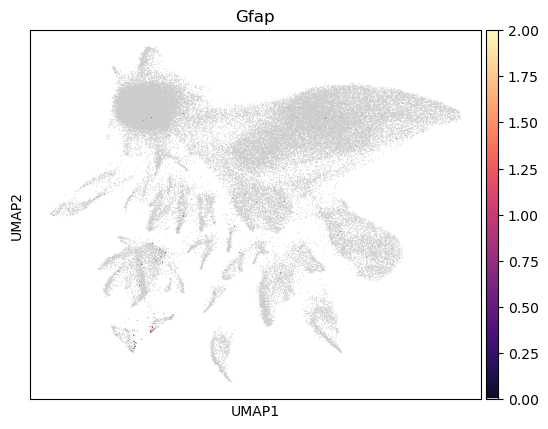

In [64]:
sc.pl.umap(adata_combined, color=['Gfap'], use_raw=True, cmap=custom_cmap1)

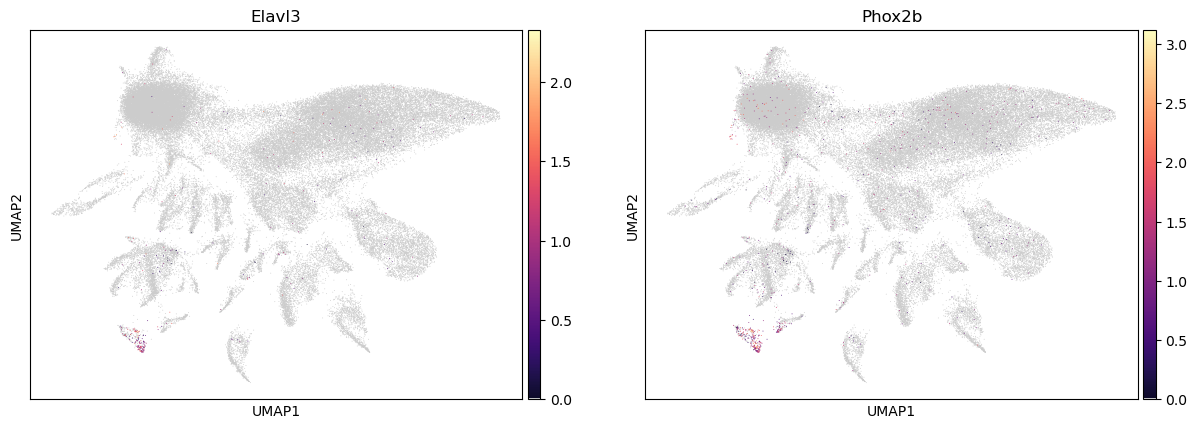

In [65]:
sc.pl.umap(adata_combined, color=['Elavl3', 'Phox2b'], use_raw=True, cmap=custom_cmap1)

## Glia

In [95]:
gbarcodes = adata_combined[(adata_combined.obs['leiden'] == '24') | (adata_combined.obs['leiden'] == '22')].obs_names
print(gbarcodes)

Index(['AACAAAGGTCGCATCG-1', 'AACTTCTAGTAGGTTA-1', 'AAGATAGAGTGCAGGT-1',
       'AATAGAGGTAGCTAAA-1', 'ACATCGATCCGCTTAC-1', 'ACTCCCACACCGGCTA-1',
       'ACTGTCCGTAGTACGG-1', 'AGAACCTAGGTTCCAT-1', 'AGAAGTAGTGCCGGTT-1',
       'AGACTCAGTTAAGTCC-1',
       ...
       'TTAGGGTCATACTTTC-1', 'TTAGTCTCAGCGACCT-1', 'TTGGGTATCATTTCGT-1',
       'TTGGTTTGTCAAAGTA-1', 'TTGTGGATCTCGGCTT-1', 'TTGTTCAAGGGTCTTT-1-1',
       'TTGTTCATCTACTATC-1', 'TTTACGTTCGTTCTGC-1', 'TTTCACAGTCCCGCAA-1',
       'TTTGATCGTGTCCACG-1'],
      dtype='object', length=630)


In [99]:
gadata = gadata[gadata.obs_names.isin(gbarcodes)]

In [100]:
gadata

View of AnnData object with n_obs × n_vars = 630 × 19033
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'batch'

In [101]:
gadata.obs_names_make_unique()

In [105]:
sc.pp.highly_variable_genes(gadata, flavor='seurat', batch_key='batch', n_top_genes=2000)
gadata.raw = gadata.copy()
gadata = gadata[:, gadata.var.highly_variable].copy()

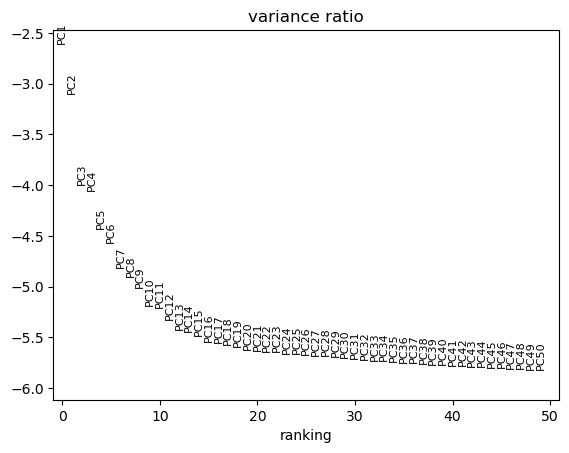

In [106]:
sc.pp.scale(gadata, max_value=10)
sc.tl.pca(gadata, svd_solver='arpack')
sc.pl.pca_variance_ratio(gadata, log=True, n_pcs = 50)

In [107]:
sc.external.pp.harmony_integrate(gadata, key='batch')
sc.pp.neighbors(gadata, n_neighbors = 10, n_pcs = 30, use_rep='X_pca_harmony')
sc.tl.umap(gadata)

2025-06-27 12:54:51,413 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-27 12:54:51,443 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-27 12:54:51,444 - harmonypy - INFO - Iteration 1 of 10
2025-06-27 12:54:51,463 - harmonypy - INFO - Iteration 2 of 10
2025-06-27 12:54:51,481 - harmonypy - INFO - Iteration 3 of 10
2025-06-27 12:54:51,498 - harmonypy - INFO - Iteration 4 of 10
2025-06-27 12:54:51,509 - harmonypy - INFO - Iteration 5 of 10
2025-06-27 12:54:51,520 - harmonypy - INFO - Iteration 6 of 10
2025-06-27 12:54:51,532 - harmonypy - INFO - Iteration 7 of 10
2025-06-27 12:54:51,540 - harmonypy - INFO - Converged after 7 iterations


In [108]:
sc.tl.leiden(gadata, resolution = 0.4)

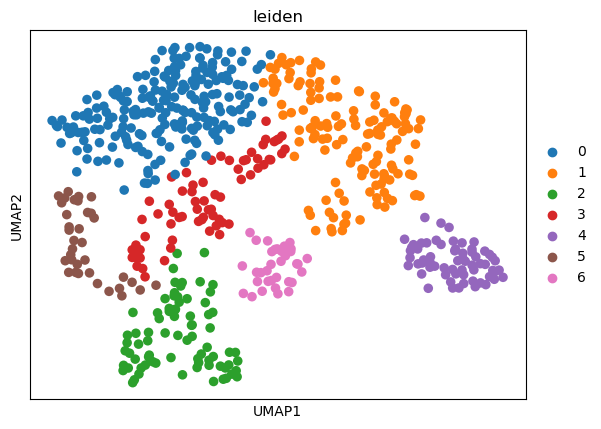

In [109]:
sc.pl.umap(gadata, color=['leiden'], use_raw=True, cmap=custom_cmap1)

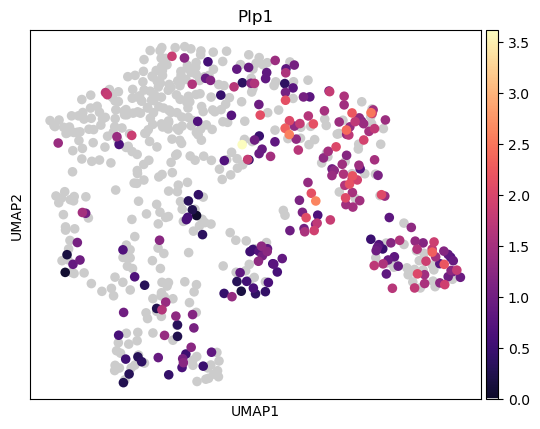

In [110]:
sc.pl.umap(gadata, color=['Plp1'], use_raw=True, cmap=custom_cmap1)

In [ ]:
sc.pl.dotplot(gadata, ['Plp1', 'Sox10', 'Gfap', 'S100b', 'Phox2b'], 'leiden')

mouse_cytokine_receptors = np.array([
    # Interleukin receptors
    "Il1r1", "Il1r2", "Il2ra", "Il2rb", "Il2rg", "Il3ra", "Il4ra", "Il5ra", "Il6ra", "Il6st",
    "Il7r", "Il9r", "Il10ra", "Il10rb", "Il11ra1", "Il12rb1", "Il12rb2", "Il13ra1", "Il13ra2",
    "Il15ra", "Il17ra", "Il17rb", "Il17rc", "Il17rd", "Il17re", "Il18r1", "Il18rap", "Il20ra",
    "Il20rb", "Il21r", "Il22ra1", "Il22ra2", "Il23r", "Il27ra", "Il28ra", "Il31ra",

    # Interferon receptors
    "Ifnar1", "Ifnar2", "Ifngr1", "Ifngr2", "Ifnlr1",

    # TNF receptor superfamily
    "Tnfrsf1a", "Tnfrsf1b", "Tnfrsf4", "Tnfrsf9", "Tnfrsf11a", "Tnfrsf13b", "Tnfrsf13c",
    "Tnfrsf14", "Tnfrsf17", "Tnfrsf18", "Tnfrsf25",

    # Chemokine receptors
    "Ccr1", "Ccr2", "Ccr3", "Ccr4", "Ccr5", "Ccr6", "Ccr7", "Ccr8", "Ccr9", "Ccr10",
    "Cxcr1", "Cxcr2", "Cxcr3", "Cxcr4", "Cxcr5", "Cxcr6", "Cx3cr1", "Xcr1",

    # CSF receptors
    "Csf1r", "Csf2ra", "Csf2rb", "Csf3r",

    # Other cytokine receptors
    "Crlf2", "Tslpr", "Osmr", "Lifr", "Cntfr", "Kit", "Flt3"
])

ctr_genes = np.intersect1d(mouse_cytokine_receptors, gadata_combined.raw.var.index)
ctr_genes

gadata_combined.raw.var[gadata_combined.raw.var.index.isin(ctr_genes)].sort_values('total_counts', ascending=False).head(20)

gadata_combined.raw.var[gadata_combined.raw.var.index.isin(ctr_genes)].sort_values('highly_variable_rank').iloc[:4,:]

sc.pl.umap(gadata_combined, color=['Il11ra1', 'Il6st'], cmap=custom_cmap1, save='glia_only_IL11.png')

sc.pl.dotplot(gadata_combined, 
              {'Glia markers': ['Plp1', 'Gfap', 'Sox10', 'S100b'], 
               'Neuron markers': ['Phox2b', 'Uchl1'], 
               'IL11 receptors': ['Il11ra1', 'Il6st']}, 
              'leiden', 
              use_raw=True,
             save='glia_only.png')